# Error model selection
With our SCB dynamic model, there are three possible error models. Let's choose which one we'll keep in the following. As for the dynamic model, for each error model we will:
1. Estimate its optimal parameters.
2. Visually check its fit against the data
3. Evaluate its weighted residuals.

Again, the last cells of this notebook compute information-based selection criteria for each of our three error models, and plot the distributions of the weighted residuals of each dynamic model.

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

def update_theme(change):
    """ display chosen theme from dropdown menu """
    name = change['new']
    html_css = set_nb_theme(name)
    display(html_css)

themes = get_themes()
print(themes)
set_nb_theme(themes[2])

['chesterish', 'grade3', 'oceans16', 'onedork']


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
%matplotlib inline

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

## Constant error
### Parameter Estimation

In [3]:
from imp import reload
import numpy as np
import SCB_estimate as SCBe
import Error_Model as EM
import Custom_Estimation_Routines as CER
import Selection_Criteria as SC
reload(CER)

data = '../data/Cell_counts_DMSO.csv'  #path to dataset
duration = 5                           #how many timepoints should we consider in the estimation

DMSO_data = np.genfromtxt(data)
DMSO_data = DMSO_data[:,:duration]
t=np.arange(duration)

xlabel='Time (days)'
titles=('Self-renewing Cells (LM1)','Living Cells (DM17)','Differentiated Cells (DM17)')

#Optimization parameters:
nruns1=100 #number of independent runs of the first optimization step
nruns2=500 #number of independent runs of the second optimization step
LHS=False #should we perform LHS on initial guesses (apparently, it's not working very well with proportional error)
maxiter=int(1e6)  #maximum duration (in evaluations of the model) of one run

In [4]:
opt1=CER.Sample_Estimate(EM.logLikelihood_ConstantError,
                         1,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0],np.array([]),False,True),
                         bounds=[(None,None)],
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS=opt1['parameters']
Ss=SCBe.S(t,DMSO_data[0,0],rhoS)
a1=np.sqrt(np.mean((DMSO_data[0]-Ss)**2))
deltaSC=rhoS+0.5*np.log(DMSO_data[0,0])

opt2=CER.Sample_Estimate(EM.logLikelihood_ConstantError,
                         3,
                         (DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False,True),
                         bounds=((None,None),(0,None),(None,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoC,deltaCB,rhoB=opt2['parameters']
TBs=SCBe.TB(t,[DMSO_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
a2=np.sqrt(np.mean((DMSO_data[1:]-TBs)**2))

Parameters_constant=np.array([rhoS[0],deltaSC[0],a1,rhoC,deltaCB,rhoB,a2])

In [4]:
save=False
if save:
    np.savetxt('../data/02_Error_Model_Selection/Constant_Error_%id.params'%(duration-1),Parameters_constant)
    
load=True
if load:
    Parameters_constant=np.loadtxt('../data/02_Error_Model_Selection/Constant_Error_%id.params'%(duration-1))
    rhoS,deltaSC,a1,rhoC,deltaCB,rhoB,a2=Parameters_constant


L1_constant=EM.logLikelihood_ConstantError(np.array([rhoS,a1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0],compute_alpha=False)
L2_constant=EM.logLikelihood_ConstantError(np.array([rhoC,deltaCB,rhoB,a2]),
                                           DMSO_data[1:],
                                           SCBe.TB,
                                           t,
                                           [DMSO_data[1,0],0,0],
                                           np.array([rhoS,deltaSC]),
                                           compute_alpha=False)

print(Parameters_constant)

[  5.88872366e-01   5.65218792e+00   2.76853264e+04   4.72792982e-01
   3.76015104e-02   1.43928245e+00   1.03179053e+04]


### Visual fit

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


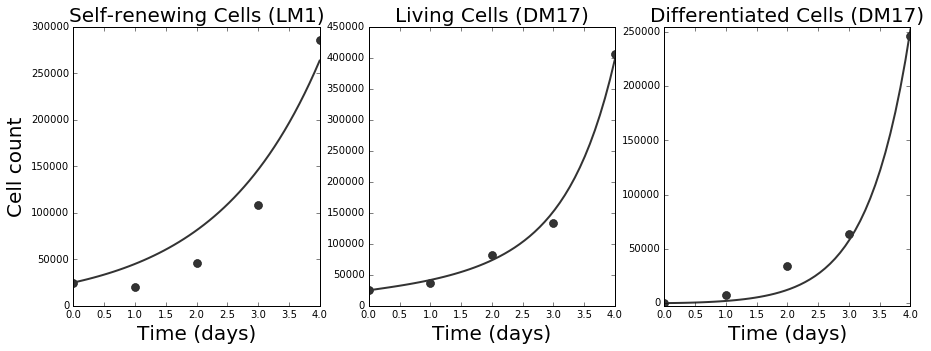

In [5]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,duration-1)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS)
TBs=SCBe.TB(T,[DMSO_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/02_Error_Model_Selection/Constant_Error_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

### Weighted Residuals

In [6]:
reload(EM)

Res_constant_S=EM.Residuals_ConstantError(np.array([rhoS,a1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0],compute_alpha=False)
Res_constant_TB=EM.Residuals_ConstantError(np.array([rhoC,deltaCB,rhoB,a2]),
                                          DMSO_data[1:],
                                          SCBe.TB,
                                          t,
                                          [DMSO_data[1,0],0,0],
                                          np.array([rhoS,deltaSC]),
                                          compute_alpha=False)
Res_constant=np.vstack((Res_constant_S[0],Res_constant_TB[0]))

## Proportional Error

In [8]:
opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0],np.array([]),False),
                         bounds=[(None,None),(0,None)],
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS,b1=opt1['parameters']
deltaSC=rhoS+0.5*np.log(DMSO_data[0,0])

opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         4,
                         (DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False),
                         bounds=((None,None),(0,None),(None,None),(0,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoC,deltaCB,rhoB,b2=opt2['parameters']

Parameters_proportional=np.array([rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2])

In [7]:
save=False
if save:
    np.savetxt('../data/02_Error_Model_Selection/Proportional_Error_%id.params'%(duration-1),Parameters_proportional)
    
load=True
if load:
    Parameters_proportional=np.loadtxt('../data/02_Error_Model_Selection/Proportional_Error_%id.params'%(duration-1))
    rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2=Parameters_proportional
    
L1_proportional=EM.logLikelihood_ProportionalError(np.array([rhoS,b1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0])
L2_proportional=EM.logLikelihood_ProportionalError(np.array([rhoC,deltaCB,rhoB,b2]),
                                                   DMSO_data[1:],
                                                   SCBe.TB,
                                                   t,
                                                   [DMSO_data[1,0],0,0],
                                                   np.array([rhoS,deltaSC]))
print(Parameters_proportional,L1_proportional,L2_proportional)

[ 0.52743838  5.59075393  0.33774221  0.48892307  0.18259922  0.91638053
  0.14792174] 105.9603556 173.921717747


### Visual fit

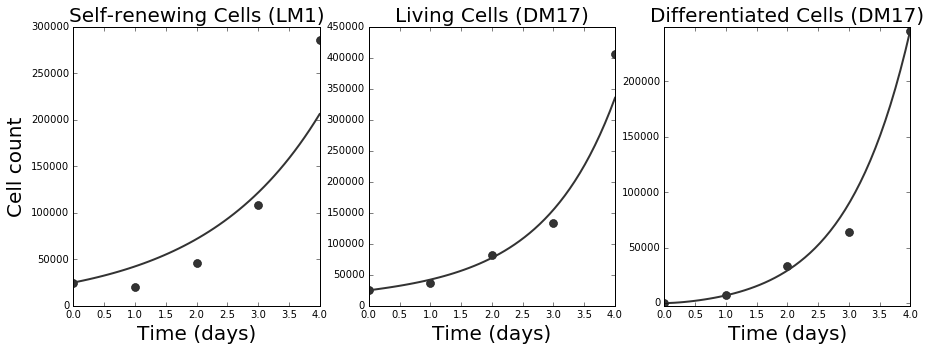

In [8]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,duration-1)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS)
TBs=SCBe.TB(T,[DMSO_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/02_Error_Model_Selection/Proportional_Error_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

In [9]:
reload(EM)

Res_proportional_S=EM.Residuals_ProportionalError(np.array([rhoS,b1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0])
Res_proportional_TB=EM.Residuals_ProportionalError(np.array([rhoC,deltaCB,rhoB,b2]),
                                          DMSO_data[1:],
                                          SCBe.TB,
                                          t,
                                          [DMSO_data[1,0],0,0],
                                          np.array([rhoS,deltaSC]))
Res_proportional=np.concatenate((Res_proportional_S,Res_proportional_TB))

## Combined Error

In [12]:
opt1=CER.Sample_Estimate(EM.logLikelihood_CombinedError,
                         3,
                         (DMSO_data[0],SCBe.S,t,DMSO_data[0,0],np.array([]),False),
                         bounds=[(None,None),(0,None),(0,None)],
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoS,a1,b1=opt1['parameters']
deltaSC=rhoS+0.5*np.log(DMSO_data[0,0])

opt2=CER.Sample_Estimate(EM.logLikelihood_CombinedError,
                        5,
                         (DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False),
                         bounds=((None,None),(0,None),(None,None),(0,None),(0,None)),
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
rhoC,deltaCB,rhoB,a2,b2=opt2['parameters']

Parameters_Combined=np.array([rhoS,deltaSC,a1,b1,rhoC,deltaCB,rhoB,a2,b2])

In [10]:
save=False
if save:
    np.savetxt('../data/02_Error_Model_Selection/Combined_Error_%id.params'%(duration-1),Parameters_Combined)
    
load=True
if load:
    Parameters_Combined=np.loadtxt('../data/02_Error_Model_Selection/Combined_Error_%id.params'%(duration-1))
    rhoS,deltaSC,a1,b1,rhoC,deltaCB,rhoB,a2,b2=Parameters_Combined

L1_combined=EM.logLikelihood_CombinedError(np.array([rhoS,a1,b1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0])
L2_combined=EM.logLikelihood_CombinedError(np.array([rhoC,deltaCB,rhoB,a2,b2]),
                                           DMSO_data[1:],
                                           SCBe.TB,
                                           t,
                                           [DMSO_data[1,0],0,0],
                                           np.array([rhoS,deltaSC]))
print(Parameters_Combined)

[ 0.52743837  5.59075392  0.          0.33774223  0.48892166  0.1825989
  0.9163826   0.          0.1479218 ]


### Visual fit

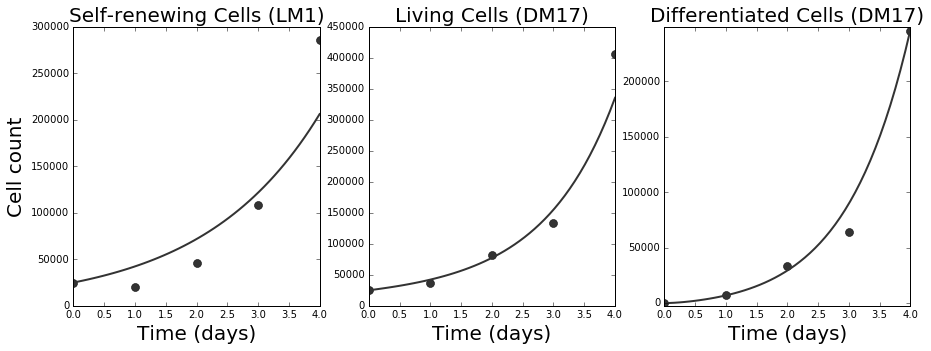

In [11]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0,duration-1)
Ss=SCBe.S(T,DMSO_data[0,0],rhoS)
TBs=SCBe.TB(T,[DMSO_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
DMSO_simul=np.vstack((Ss,TBs))

for i in range(3):
    ax[i].plot(t,DMSO_data[i],'o',markersize=8,c='0.2')
    ax[i].plot(T,DMSO_simul[i],'-',linewidth=2,c='0.2')
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(xlabel, fontsize=20)
ax[0].set_ylabel("Cell count", fontsize=20)
max_diff=np.max(np.concatenate([DMSO_simul[2], DMSO_data[2]]))
ax[2].set_ylim((-0.01*max_diff,1.01*max_diff))

savefig=False
if savefig:
    plt.savefig('../figures/02_Error_Model_Selection/Combined_Error_Fit_%id.pdf'%(duration-1), bbox_inches='tight', dpi='figure')

In [12]:
reload(EM)

Res_combined_S=EM.Residuals_CombinedError(np.array([rhoS,a1,b1]),DMSO_data[0],SCBe.S,t,DMSO_data[0,0])
Res_combined_TB=EM.Residuals_CombinedError(np.array([rhoC,deltaCB,rhoB,a2,b2]),
                                          DMSO_data[1:],
                                          SCBe.TB,
                                          t,
                                          [DMSO_data[1,0],0,0],
                                          np.array([rhoS,deltaSC]))
Res_combined=np.concatenate((Res_combined_S,Res_combined_TB))

## Residuals distributions

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 3 x 5)
  '(shape is %d x %d)' % inp.shape[::-1])
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


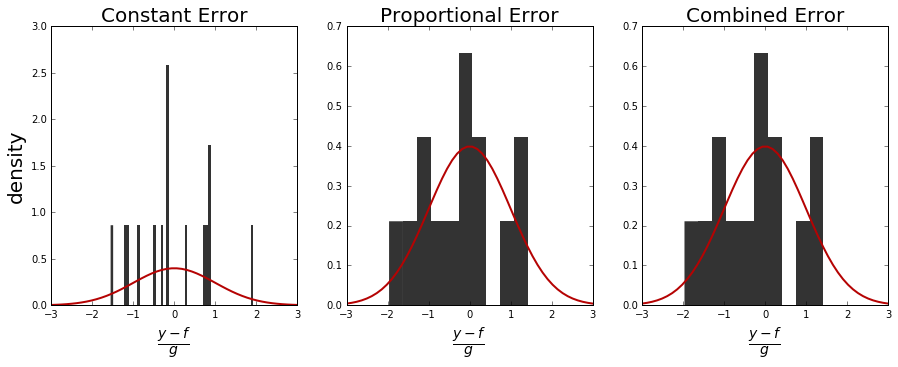

In [13]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

xrange=np.linspace(-3,3)
titles=('Constant Error','Proportional Error','Combined Error')

Res=(Res_constant, Res_proportional, Res_combined)

for i in range(3):
    ax[i].hist(Res[i],bins=10,facecolor='0.2',normed=1,edgecolor='none')
    ax[i].plot(xrange, mlab.normpdf(xrange,0,1), '-', c='#b50303', linewidth=2)
    ax[i].set_title(titles[i],fontsize=20)
    ax[i].set_xlabel(r'$\frac{y-f}{g}$', fontsize=20)
ax[0].set_ylabel('density', fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/02_Error_Model_Selection/Error_Models_Residuals_distributions_%id.pdf'%(duration-1),dpi='figure',bbox_inches='tight')

## Comparing parameters

In [14]:
Parameters=(Parameters_constant,Parameters_proportional,Parameters_Combined)

line_names=('rhoS','deltaSC','a1','b1','rhoC','deltaCB','rhoB','a2','b2')
column_names=('Parameter','Const','Prop','Comb')

jump=((3,8),(2,7),[])
single_dash=((2,7),[],[])

header=''
for i in range(len(column_names)):
    header+='%s:\t'%column_names[i]
    if i>=1:
        header+='\t'
header+='\n'
for i in range(len(column_names)):
    header+='%s\t'%('-'*(len(column_names[i])+1))
    if i>=1:
        header+='\t'

print(header)
k=[0,0,0]
for i in range(len(line_names)):
    line=line_names[i]+'\t\t'
    for j in range(3):
        if not i in jump[j]:
            if i in single_dash[j]:
                line+='%.3g\t'%Parameters[j][k[j]]
            else:
                line+='%.3g\t\t'%Parameters[j][k[j]]
            k[j]+=1
        else:
            line+='-\t\t'
    #print(i,j,k)
    print(line)

Parameter:	Const:		Prop:		Comb:		
----------	------		-----		-----		
rhoS		0.589		0.527		0.527		
deltaSC		5.65		5.59		5.59		
a1		2.77e+04	-		0		
b1		-		0.338		0.338		
rhoC		0.473		0.489		0.489		
deltaCB		0.0376		0.183		0.183		
rhoB		1.44		0.916		0.916		
a2		1.03e+04	-		0		
b2		-		0.148		0.148		


## Model Selection

In [15]:
line_names=('Const','Prop','Comb')
column_names=('Model','-2log(L1)','-2log(L2)','AIC','AICc','D_AICc','w_AICc')

L1 = (L1_constant,L1_proportional,L1_combined)  #likelihood in the first estimation step
L2 = (L2_constant,L2_proportional,L2_combined)  #likelihood in the second estimation step
k  = (6,6,8)    #number of estimated parameters
n  = (3*duration,3*duration,3*duration) #sample size
AIC = list(SC.AIC(L1[i]+L2[i],k[i]) for i in range(3))
AICc= list(SC.AICc(L1[i]+L2[i],n[i],k[i]) for i in range(3))
D_AICc = np.array(AICc)-np.min(AICc)
w_AICc = np.exp(-0.5*D_AICc)/np.sum(np.exp(-0.5*D_AICc))

header=''
for i in range(len(column_names)):
    header+='%s:\t'%column_names[i]
header+='\n'
for i in range(len(column_names)):
    header+='%s\t'%('-'*(len(column_names[i])+1))

print(header)
for i in range(len(line_names)):
    line=line_names[i]+'\t'
    line+='%.4g\t\t'%L1[i]
    line+='%.4g\t\t'%L2[i]
    line+='%.4g\t'%AIC[i]
    line+='%.4g\t'%AICc[i]
    line+='%.4g\t'%D_AICc[i]
    line+='%.6g\t'%w_AICc[i]
    print(line)

Model:	-2log(L1):	-2log(L2):	AIC:	AICc:	D_AICc:	w_AICc:	
------	----------	----------	----	-----	-------	-------	
Const	107.3		194.8		314.1	324.6	22.24	1.48311e-05	
Prop	106		173.9		291.9	302.4	0	0.999827	
Comb	106		173.9		295.9	319.9	17.5	0.000158434	
